# Group 2

## Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, log_loss

from xgboost import XGBClassifier
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from pdpbox import pdp
import shap

In [2]:
df = pd.read_excel('dataproject2024.xlsx')
df

ID  Job tenure  Age  Car price  Funding amount  Down payment  \
0        1          34   55       4875            3087             0   
1        2           5   29      13000           13000             0   
2        3          14   38      17190           14190             0   
3        4          16   37      22773           23568             0   
4        5           1   61       7700            8526             0   
...    ...         ...  ...        ...             ...           ...   
7425  7426           9   38       4502            4856             0   
7426  7427           1   33      22900           17900             0   
7427  7428           3   27      25858           25972             0   
7428  7429           6   32      12300           11300             0   
7429  7430           5   47      15900           17764             0   

      Loan duration  Monthly payment  Credit event  Married  Homeowner  \
0                36         0.047895             0        1          1   
1                60         0.091667             0        0          0   
2                60         0.088235             0        0          0   
3                48         0.110084             0        1          1   
4                48         0.123404             0        1          0   
...             ...              ...           ...      ...        ...   
7425             48         0.083846             1        0          0   
7426             60         0.098000             0        0          0   
7427             24         0.181667             0        0          0   
7428             72         0.091963             0        0          1   
7429             96         0.135000             0        1          0   

      Default (y)  Pred_default (y_hat)        PD  Group  
0               0                     0  0.024480      1  
1               1                     0  0.331661      0  
2               0                     0  0.187505      0  
3               0                     0  0.035441      1  
4               1                     0  0.340883      0  
...           ...                   ...       ...    ...  
7425            1                     0  0.217708      0  
7426            0                     0  0.063937      0  
7427            0                     1  0.630863      0  
7428            0                     0  0.067551      0  
7429            0                     0  0.150553      0  

[7430 rows x 15 columns]

## Step 1: Use the estimated default probability (PD) provided in the dataset. Implement one or two surrogate model(s) to interpret the unknown model used to generate PD.

**We use the unknown model's predictions (`PD`) as the target variable and use original features to train our surrogate model**

In [3]:
y = df['PD']
X = df[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]


# train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### First surrogate: LinearRegression

First we build the surrogate model

In [4]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.025293393693871583
R-squared: 0.42325844480117025


In [5]:
# rajouter commentaire performance nulle du modèle surrogate 

Then we interpret the coefficients

           Feature  Coefficient
0       Job tenure    -0.002953
1              Age    -0.001269
2        Car price    -0.000021
3   Funding amount     0.000026
4     Down payment     0.081968
5    Loan duration     0.001142
6  Monthly payment     0.291974
7     Credit event     0.315471
8          Married    -0.072892
9        Homeowner    -0.064714


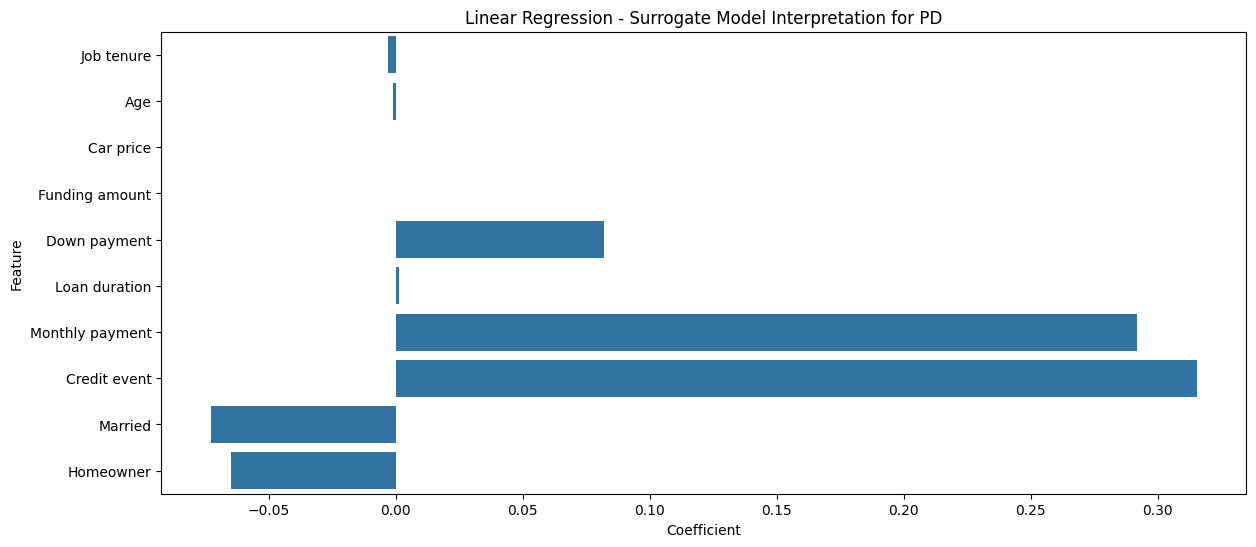

In [6]:
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lr_model.coef_
})

print(coefficients)

# plotting
plt.figure(figsize=(14,6))
sns.barplot(x='Coefficient', y='Feature', data=coefficients)
plt.title('Linear Regression - Surrogate Model Interpretation for PD')
plt.show()

This plot helps in interpreting the unknown model! We see how different features have an impact on the estimated default probability. For instance:

- **Credit event** has the largest positive coefficient. This means that if a credit event occurred it significantly increases the probability of default. This suggests that credit history plays a crucial role in predicting default likelihood

- **Monthly payment** also has a big positive effect meaning that higher monthly payments are associated with a higher probability of default. This could be due to the financial burden of higher loan payments on the borrower

- **Marital status** and **Homeownership** on the other hand have negative coefficients implying that being married or a homeowner reduces the probability of default. These factors might indicate more financial stability, leading to lower risk

### Second surrogate: DecisionTreeRegressor

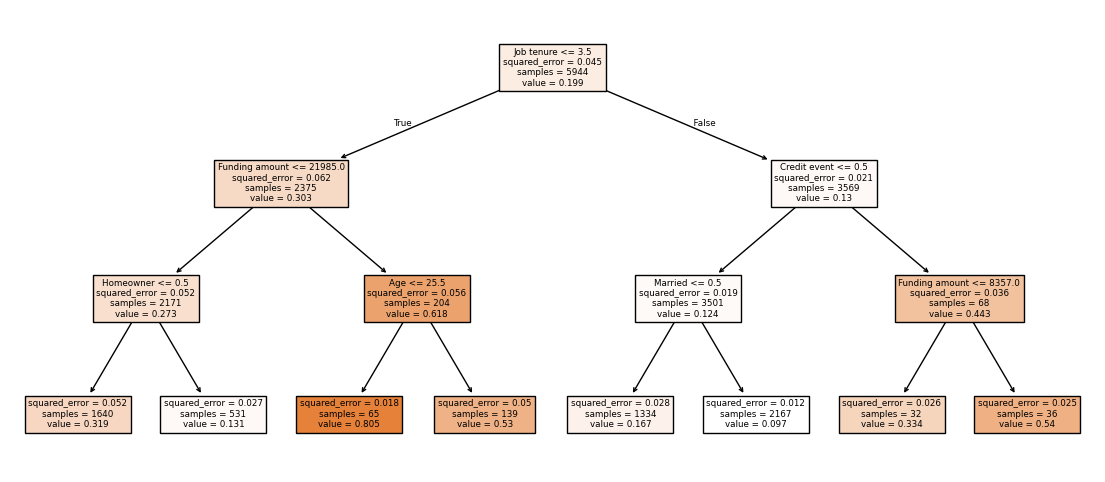

Train Score: 0.35382098105428017
Test Score: 0.30911991669819894


In [7]:
surrogate_model = DecisionTreeRegressor(max_depth=3, random_state=42)
surrogate_model.fit(X_train, y_train)

plt.figure(figsize=(14,6))
plot_tree(surrogate_model, feature_names=X.columns, filled=True)
plt.show()

train_score = surrogate_model.score(X_train, y_train)
test_score = surrogate_model.score(X_test, y_test)

print(f'Train Score: {train_score}')
print(f'Test Score: {test_score}')

In [8]:
# add commentaire feature importance

## Step 2: Estimate your own black-box machine learning model forecasting default. Each model is specific to a group of students and cannot be developed in collaboration with another group.

We often use XGBoost for its powerful and flexible ML algorithms but in fact it can be considered a black-box model and although it often leads to very good results, it is often hard to interpret them !

In [9]:
df.columns

Index(['ID', 'Job tenure', 'Age', 'Car price', 'Funding amount',
       'Down payment', 'Loan duration', 'Monthly payment', 'Credit event',
       'Married', 'Homeowner', 'Default (y)', 'Pred_default (y_hat)', 'PD',
       'Group'],
      dtype='object')

In [10]:
y = df['Default (y)']
X = df[['Job tenure', 'Age', 'Car price', 'Funding amount', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
xgb_model = XGBClassifier(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8129205921938089
Confusion Matrix:
[[1143   62]
 [ 216   65]]
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      1205
           1       0.51      0.23      0.32       281

    accuracy                           0.81      1486
   macro avg       0.68      0.59      0.61      1486
weighted avg       0.78      0.81      0.78      1486



In order to make the model more performant (and more complex as we are creating a black-box !) we hyper-parameter tune our model using optuna:

In [12]:
def objective(trial):
    # tuning hyperparameters
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 1500),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-4, 0.3, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 10),
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-8, 1.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-8, 1.0, log=True),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
        'eta': trial.suggest_float('eta', 0.01, 0.3),
        'base_score': trial.suggest_float('base_score', 0.5, 0.7),
        'random_state': 42
    }

    xgb_model = XGBClassifier(**param, objective='binary:logistic')
    xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

    y_pred = xgb_model.predict(X_test)

    return 1 - accuracy_score(y_test, y_pred)  # minimize error

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-09-29 14:20:36,166] A new study created in memory with name: no-name-56431205-6859-4269-8a49-e1b533ba98d5
[I 2024-09-29 14:20:37,071] Trial 0 finished with value: 0.3216689098250336 and parameters: {'n_estimators': 578, 'max_depth': 6, 'learning_rate': 0.0016023294061278835, 'subsample': 0.7590349135798744, 'colsample_bytree': 0.5146621510702323, 'gamma': 7.006983206565137, 'reg_alpha': 8.879844502912112e-08, 'reg_lambda': 0.28205368710335454, 'min_child_weight': 2, 'scale_pos_weight': 2.573636278454564, 'eta': 0.12749706568990662, 'base_score': 0.6903253735627768}. Best is trial 0 with value: 0.3216689098250336.
[I 2024-09-29 14:20:37,756] Trial 1 finished with value: 0.1877523553162853 and parameters: {'n_estimators': 427, 'max_depth': 12, 'learning_rate': 0.019903402395533468, 'subsample': 0.9708422940062771, 'colsample_bytree': 0.9627921059240047, 'gamma': 2.4514789256052016, 'reg_alpha': 0.003808315946824104, 'reg_lambda': 0.004611109608646936, 'min_child_weight': 9, 'scal

In [13]:
best_params = study.best_params
print(f"Best hyperparameters: {study.best_params}")

xgb_model = XGBClassifier(**best_params, objective='binary:logistic')
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Best hyperparameters: {'n_estimators': 427, 'max_depth': 12, 'learning_rate': 0.019903402395533468, 'subsample': 0.9708422940062771, 'colsample_bytree': 0.9627921059240047, 'gamma': 2.4514789256052016, 'reg_alpha': 0.003808315946824104, 'reg_lambda': 0.004611109608646936, 'min_child_weight': 9, 'scale_pos_weight': 1.4693340229124343, 'eta': 0.21986057275835902, 'base_score': 0.6709264166671883}
Accuracy: 0.8169582772543742
Confusion Matrix:
[[1112   93]
 [ 179  102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1205
           1       0.52      0.36      0.43       281

    accuracy                           0.82      1486
   macro avg       0.69      0.64      0.66      1486
weighted avg       0.80      0.82      0.80      1486



## Step 3: Analyze the forecasting performance of your own model.

In [14]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Confusion Matrix:\n{conf_matrix}")
print(f"Classification Report:\n{classification_rep}")

Accuracy: 0.8169582772543742
Confusion Matrix:
[[1112   93]
 [ 179  102]]
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.92      0.89      1205
           1       0.52      0.36      0.43       281

    accuracy                           0.82      1486
   macro avg       0.69      0.64      0.66      1486
weighted avg       0.80      0.82      0.80      1486



Visualize Predicted vs. Actual Values

In [15]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score

# Calculate Precision, Recall, F1 Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.5230769230769231
Recall: 0.36298932384341637
F1 Score: 0.42857142857142855


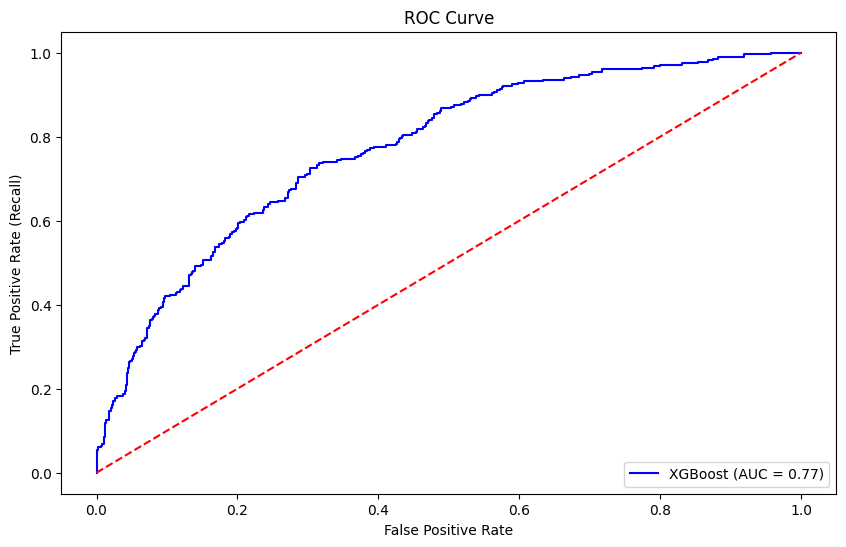

ROC AUC Score: 0.7724989294310479


In [16]:
# ROC Curve and AUC
y_pred_prob = xgb_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
roc_auc = roc_auc_score(y_test, y_pred_prob)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='blue', label=f'XGBoost (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

print(f"ROC AUC Score: {roc_auc}")

**0.78** indicates that the model is doing well at distinguishing between default vs non-default

## Step 4: Global interpretability: Implement one or two surrogate model(s) to interpret your own model. Compare the results provided in Steps 1 and 4.

In [17]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

y_surrogate = xgb_model.predict(X_train)

### Logistic Regression surrogate

In [18]:
lr_surrogate = LogisticRegression()
lr_surrogate.fit(X_train, y_surrogate)

# predictions for surrogate model
y_surrogate_pred_proba = lr_surrogate.predict_proba(X_test) # predict_proba for logloss metric
y_surrogate_pred = lr_surrogate.predict(X_test)

# predictions for black-box (xgb) model
y_blackbox_pred_proba = xgb_model.predict_proba(X_test)
y_blackbox_pred = xgb_model.predict(X_test)

### Coefficients for Logistic Regression surrogate

In [19]:
# Surrogate vs Black Box
accuracy_surrogate_blackbox = accuracy_score(y_blackbox_pred, y_surrogate_pred)
f1_surrogate_blackbox = f1_score(y_blackbox_pred, y_surrogate_pred, average='weighted')
logloss_surrogate_blackbox = log_loss(y_blackbox_pred, y_surrogate_pred_proba)

print("Surrogate vs. Black Box:")
print(f"  Accuracy: {accuracy_surrogate_blackbox:.4f}")
print(f"  F1 Score: {f1_surrogate_blackbox:.4f}")
print(f"  Log Loss: {logloss_surrogate_blackbox:.4f}")


# Surrogate vs Real Y
accuracy_surrogate_real = accuracy_score(y_test, y_surrogate_pred)
f1_surrogate_real = f1_score(y_test, y_surrogate_pred, average='weighted')
logloss_surrogate_real = log_loss(y_test, y_surrogate_pred_proba)

print("\nSurrogate vs. Real Y:")
print(f"  Accuracy: {accuracy_surrogate_real:.4f}")
print(f"  F1 Score: {f1_surrogate_real:.4f}")
print(f"  Log Loss: {logloss_surrogate_real:.4f}")


# Black Box vs Real Y (for reference)
accuracy_blackbox_real = accuracy_score(y_test, y_blackbox_pred)
f1_blackbox_real = f1_score(y_test, y_blackbox_pred, average='weighted')
logloss_blackbox_real = log_loss(y_test, y_blackbox_pred_proba)

print("\nBlack Box vs. Real Y:")
print(f"  Accuracy: {accuracy_blackbox_real:.4f}")
print(f"  F1 Score: {f1_blackbox_real:.4f}")
print(f"  Log Loss: {logloss_blackbox_real:.4f}")

Surrogate vs. Black Box:
  Accuracy: 0.8903
  F1 Score: 0.8763
  Log Loss: 0.2615

Surrogate vs. Real Y:
  Accuracy: 0.8136
  F1 Score: 0.7784
  Log Loss: 0.4853

Black Box vs. Real Y:
  Accuracy: 0.8170
  F1 Score: 0.8036
  Log Loss: 0.4213


**Comment** ^^

#### Now let's interpret the surrogate model


Feature Importance:
           Feature  Importance
0       Job tenure   -0.122468
9        Homeowner   -0.058902
8          Married   -0.057211
1              Age   -0.038460
7     Credit event    0.025849
5    Loan duration   -0.005508
4     Down payment   -0.001533
6  Monthly payment    0.001482
3   Funding amount    0.000579
2        Car price   -0.000510


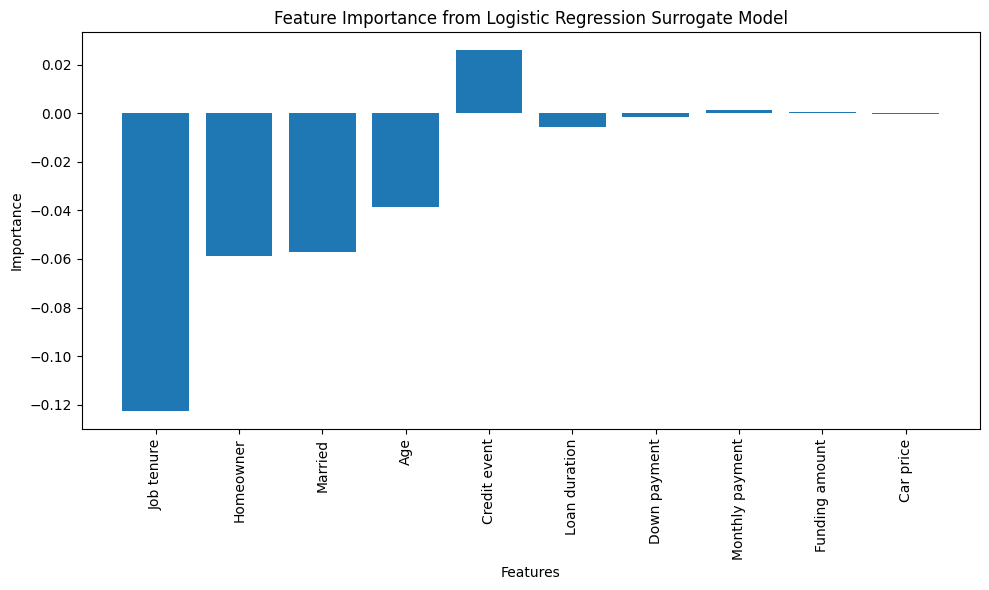

In [20]:
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lr_surrogate.coef_[0]
})
feature_importance = feature_importance.sort_values('Importance', key=abs, ascending=False)
print("\nFeature Importance:")
print(feature_importance)

# feature importance

plt.figure(figsize=(10, 6))
plt.bar(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance from Logistic Regression Surrogate Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

##### outdated ! comment new graph


The Logistic Regression surrogate provides insight into how each feature affects the probability of default:

- **Credit Event** has the largest positive coefficient (2.03), indicating that having a credit event significantly increases the probability of default
- **Monthly Payment** and **Funding Amount** also show positive coefficients, suggesting higher values increase default risk, though their impact is smaller
- **Marital Status** and **Homeownership** have large negative coefficients, indicating that being married (-2.43) or a homeowner (-1.67) significantly reduces the probability of default, likely reflecting greater financial stability
- **Job Tenure** has a modest negative effect, implying longer employment reduces default risk

### Decision tree classifier surrogate model

In [21]:
from sklearn.tree import DecisionTreeClassifier

dt_surrogate = DecisionTreeClassifier(max_depth=5) 
dt_surrogate.fit(X_train, y_surrogate)

# Predictions for surrogate model
y_dt_surrogate_pred_proba = dt_surrogate.predict_proba(X_test)
y_dt_surrogate_pred = dt_surrogate.predict(X_test)

### Comparing performance metrics

In [22]:
# Surrogate vs Black Box
accuracy_dt_surrogate_blackbox = accuracy_score(y_blackbox_pred, y_dt_surrogate_pred)
f1_dt_surrogate_blackbox = f1_score(y_blackbox_pred, y_dt_surrogate_pred, average='weighted')
logloss_dt_surrogate_blackbox = log_loss(y_blackbox_pred, y_dt_surrogate_pred_proba)

print("Decision Tree Surrogate vs. Black Box:")
print(f"  Accuracy: {accuracy_dt_surrogate_blackbox:.4f}")
print(f"  F1 Score: {f1_dt_surrogate_blackbox:.4f}")
print(f"  Log Loss: {logloss_dt_surrogate_blackbox:.4f}")

# Surrogate vs Real Y
accuracy_dt_surrogate_real = accuracy_score(y_test, y_dt_surrogate_pred)
f1_dt_surrogate_real = f1_score(y_test, y_dt_surrogate_pred, average='weighted')
logloss_dt_surrogate_real = log_loss(y_test, y_dt_surrogate_pred_proba)

print("\nDecision Tree Surrogate vs. Real Y:")
print(f"  Accuracy: {accuracy_dt_surrogate_real:.4f}")
print(f"  F1 Score: {f1_dt_surrogate_real:.4f}")
print(f"  Log Loss: {logloss_dt_surrogate_real:.4f}")

Decision Tree Surrogate vs. Black Box:
  Accuracy: 0.9071
  F1 Score: 0.8916
  Log Loss: 0.3011

Decision Tree Surrogate vs. Real Y:
  Accuracy: 0.8156
  F1 Score: 0.7746
  Log Loss: 0.5857


#### Now let's interpret the second surrogate model


Feature Importance from Decision Tree Surrogate:
           Feature  Importance
0       Job tenure    0.327427
3   Funding amount    0.243286
1              Age    0.154681
9        Homeowner    0.112330
7     Credit event    0.058652
2        Car price    0.034626
8          Married    0.034199
5    Loan duration    0.027763
6  Monthly payment    0.007036
4     Down payment    0.000000


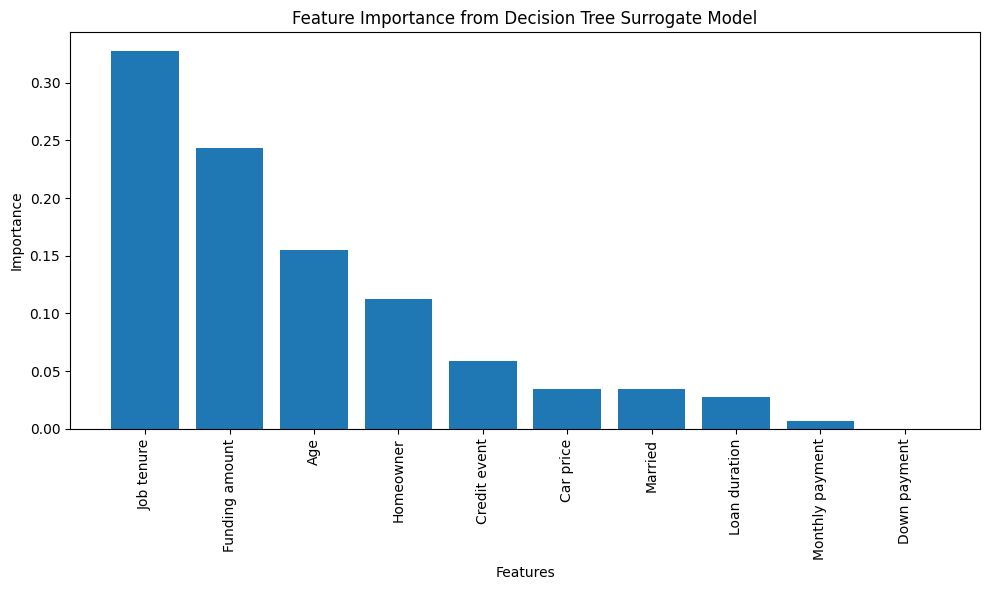

In [23]:
feature_importance_dt = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': dt_surrogate.feature_importances_
})
feature_importance_dt = feature_importance_dt.sort_values('Importance', ascending=False)

print("\nFeature Importance from Decision Tree Surrogate:")
print(feature_importance_dt)

# Feature importance plot
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_dt['Feature'], feature_importance_dt['Importance'])
plt.title('Feature Importance from Decision Tree Surrogate Model')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

**comment ! ^^^^^^**

## Step 5: Global interpretability: Implement the PDP method to interpret your own model. Compare the results provided in Steps 4 and 5.

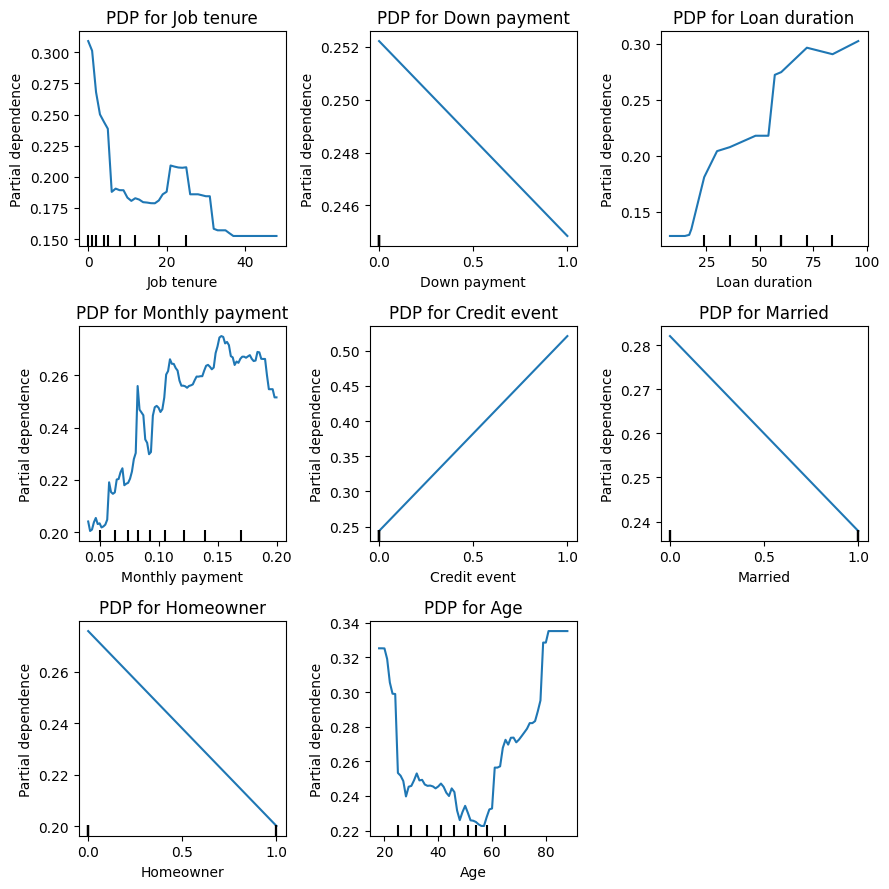

In [24]:
from sklearn.inspection import PartialDependenceDisplay

features = ['Job tenure', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner', 'Age']

#  PDP for each feature
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(9, 9))
axs = axs.flatten()

for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        xgb_model, 
        X_test, 
        [feature],
        ax=axs[i],
        kind='average'
    )
    axs[i].set_title(f'PDP for {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Avg Predicted Probability')
    axs[i].grid(True)

# removing unused plots
for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Comment ^^^

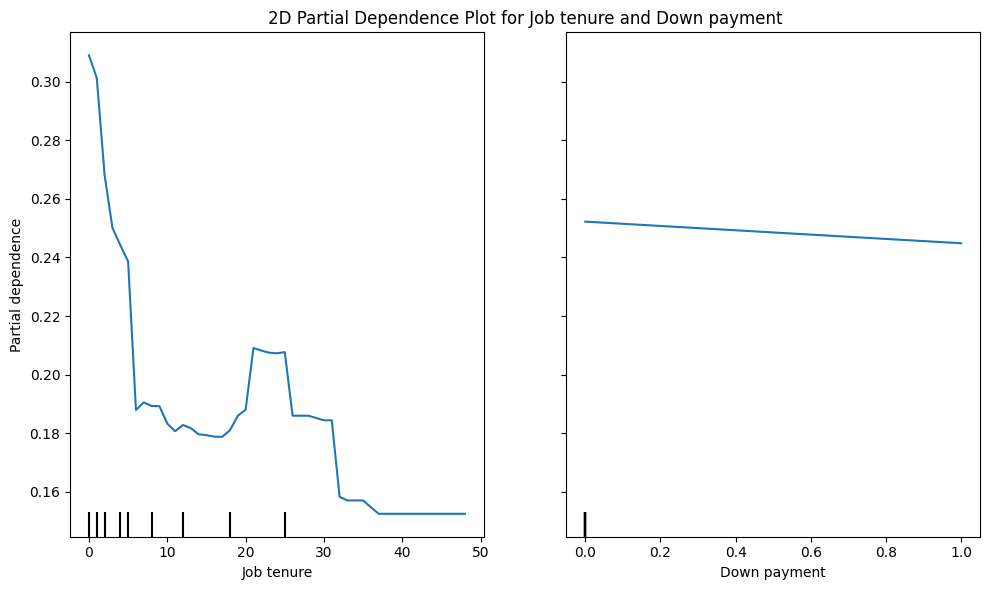


Feature Importance based on PDP ranges:
Credit event: 0.2770
Loan duration: 0.1742
Job tenure: 0.1565
Age: 0.1125
Homeowner: 0.0756
Monthly payment: 0.0746
Married: 0.0442
Down payment: 0.0074


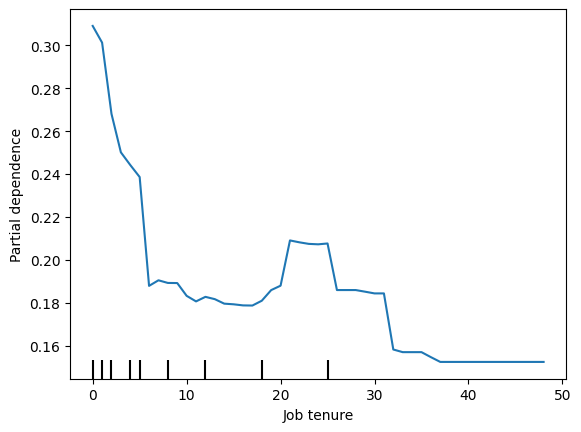

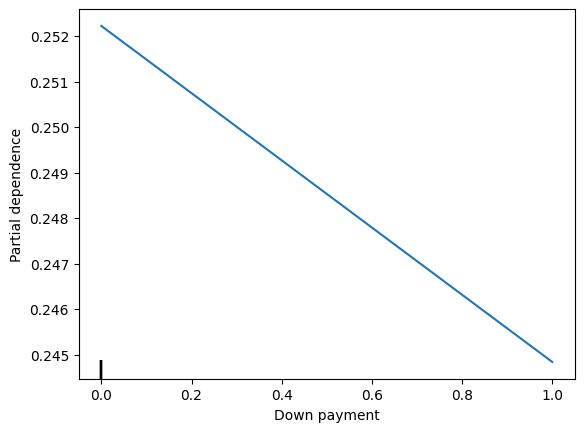

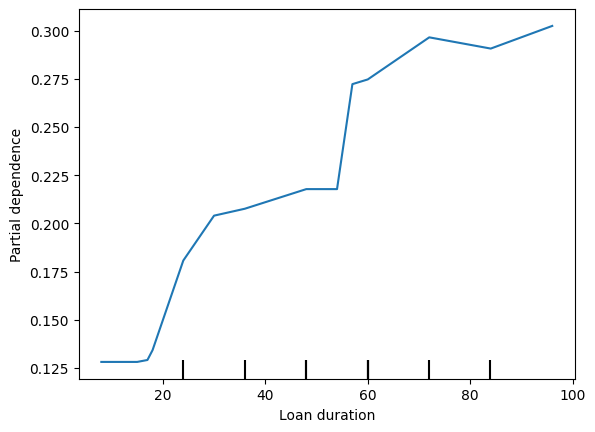

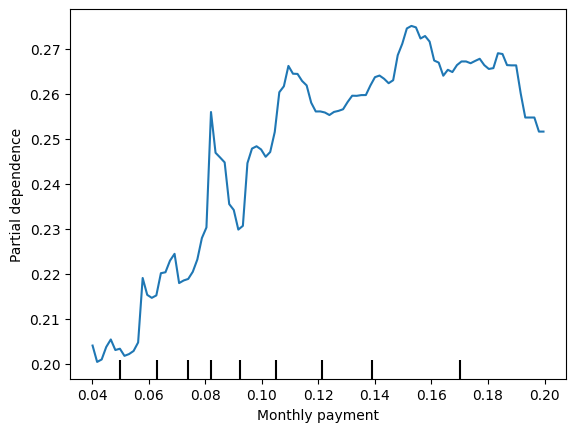

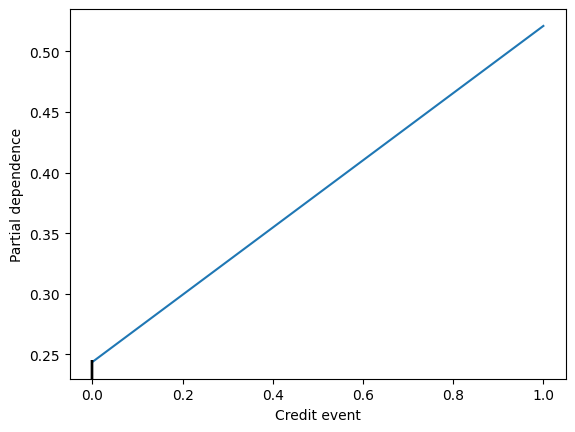

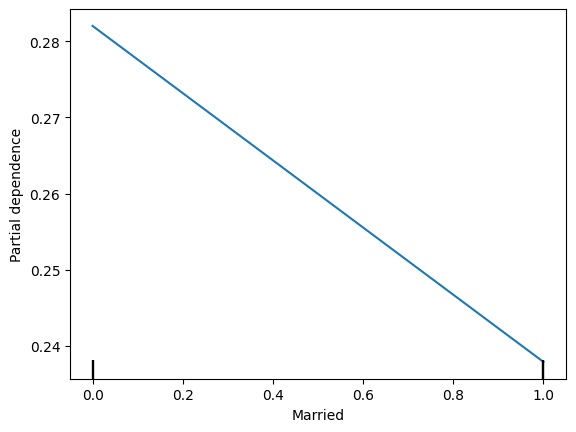

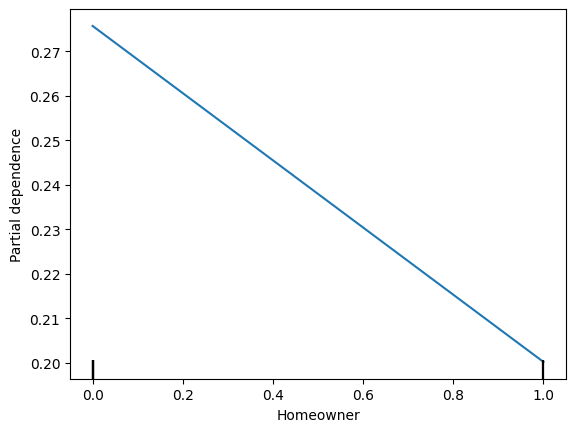

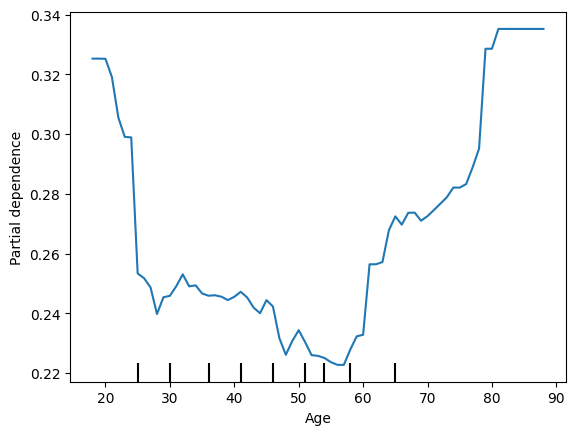

In [25]:
# exploring interaction between two features
feature_pair = ['Job tenure', 'Down payment']

fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    xgb_model, 
    X_test, 
    feature_pair,
    ax=ax,
    kind='average'
)

ax.set_title(f'2D Partial Dependence Plot for {feature_pair[0]} and {feature_pair[1]}')
plt.tight_layout()
plt.show()

# Print feature importances based on PDP ranges
pdp_importances = []
for feature in features:
    pdp = PartialDependenceDisplay.from_estimator(xgb_model, X_test, [feature], kind='average')
    pdp_range = np.ptp(pdp.pd_results[0]['average'][0])
    pdp_importances.append((feature, pdp_range))

pdp_importances.sort(key=lambda x: x[1], reverse=True)
print("\nFeature Importance based on PDP ranges:")
for feature, importance in pdp_importances:
    print(f"{feature}: {importance:.4f}")

### Comment ^^^

## Step 6: Local interpretability: Implement the ICE method to interpret your own model.

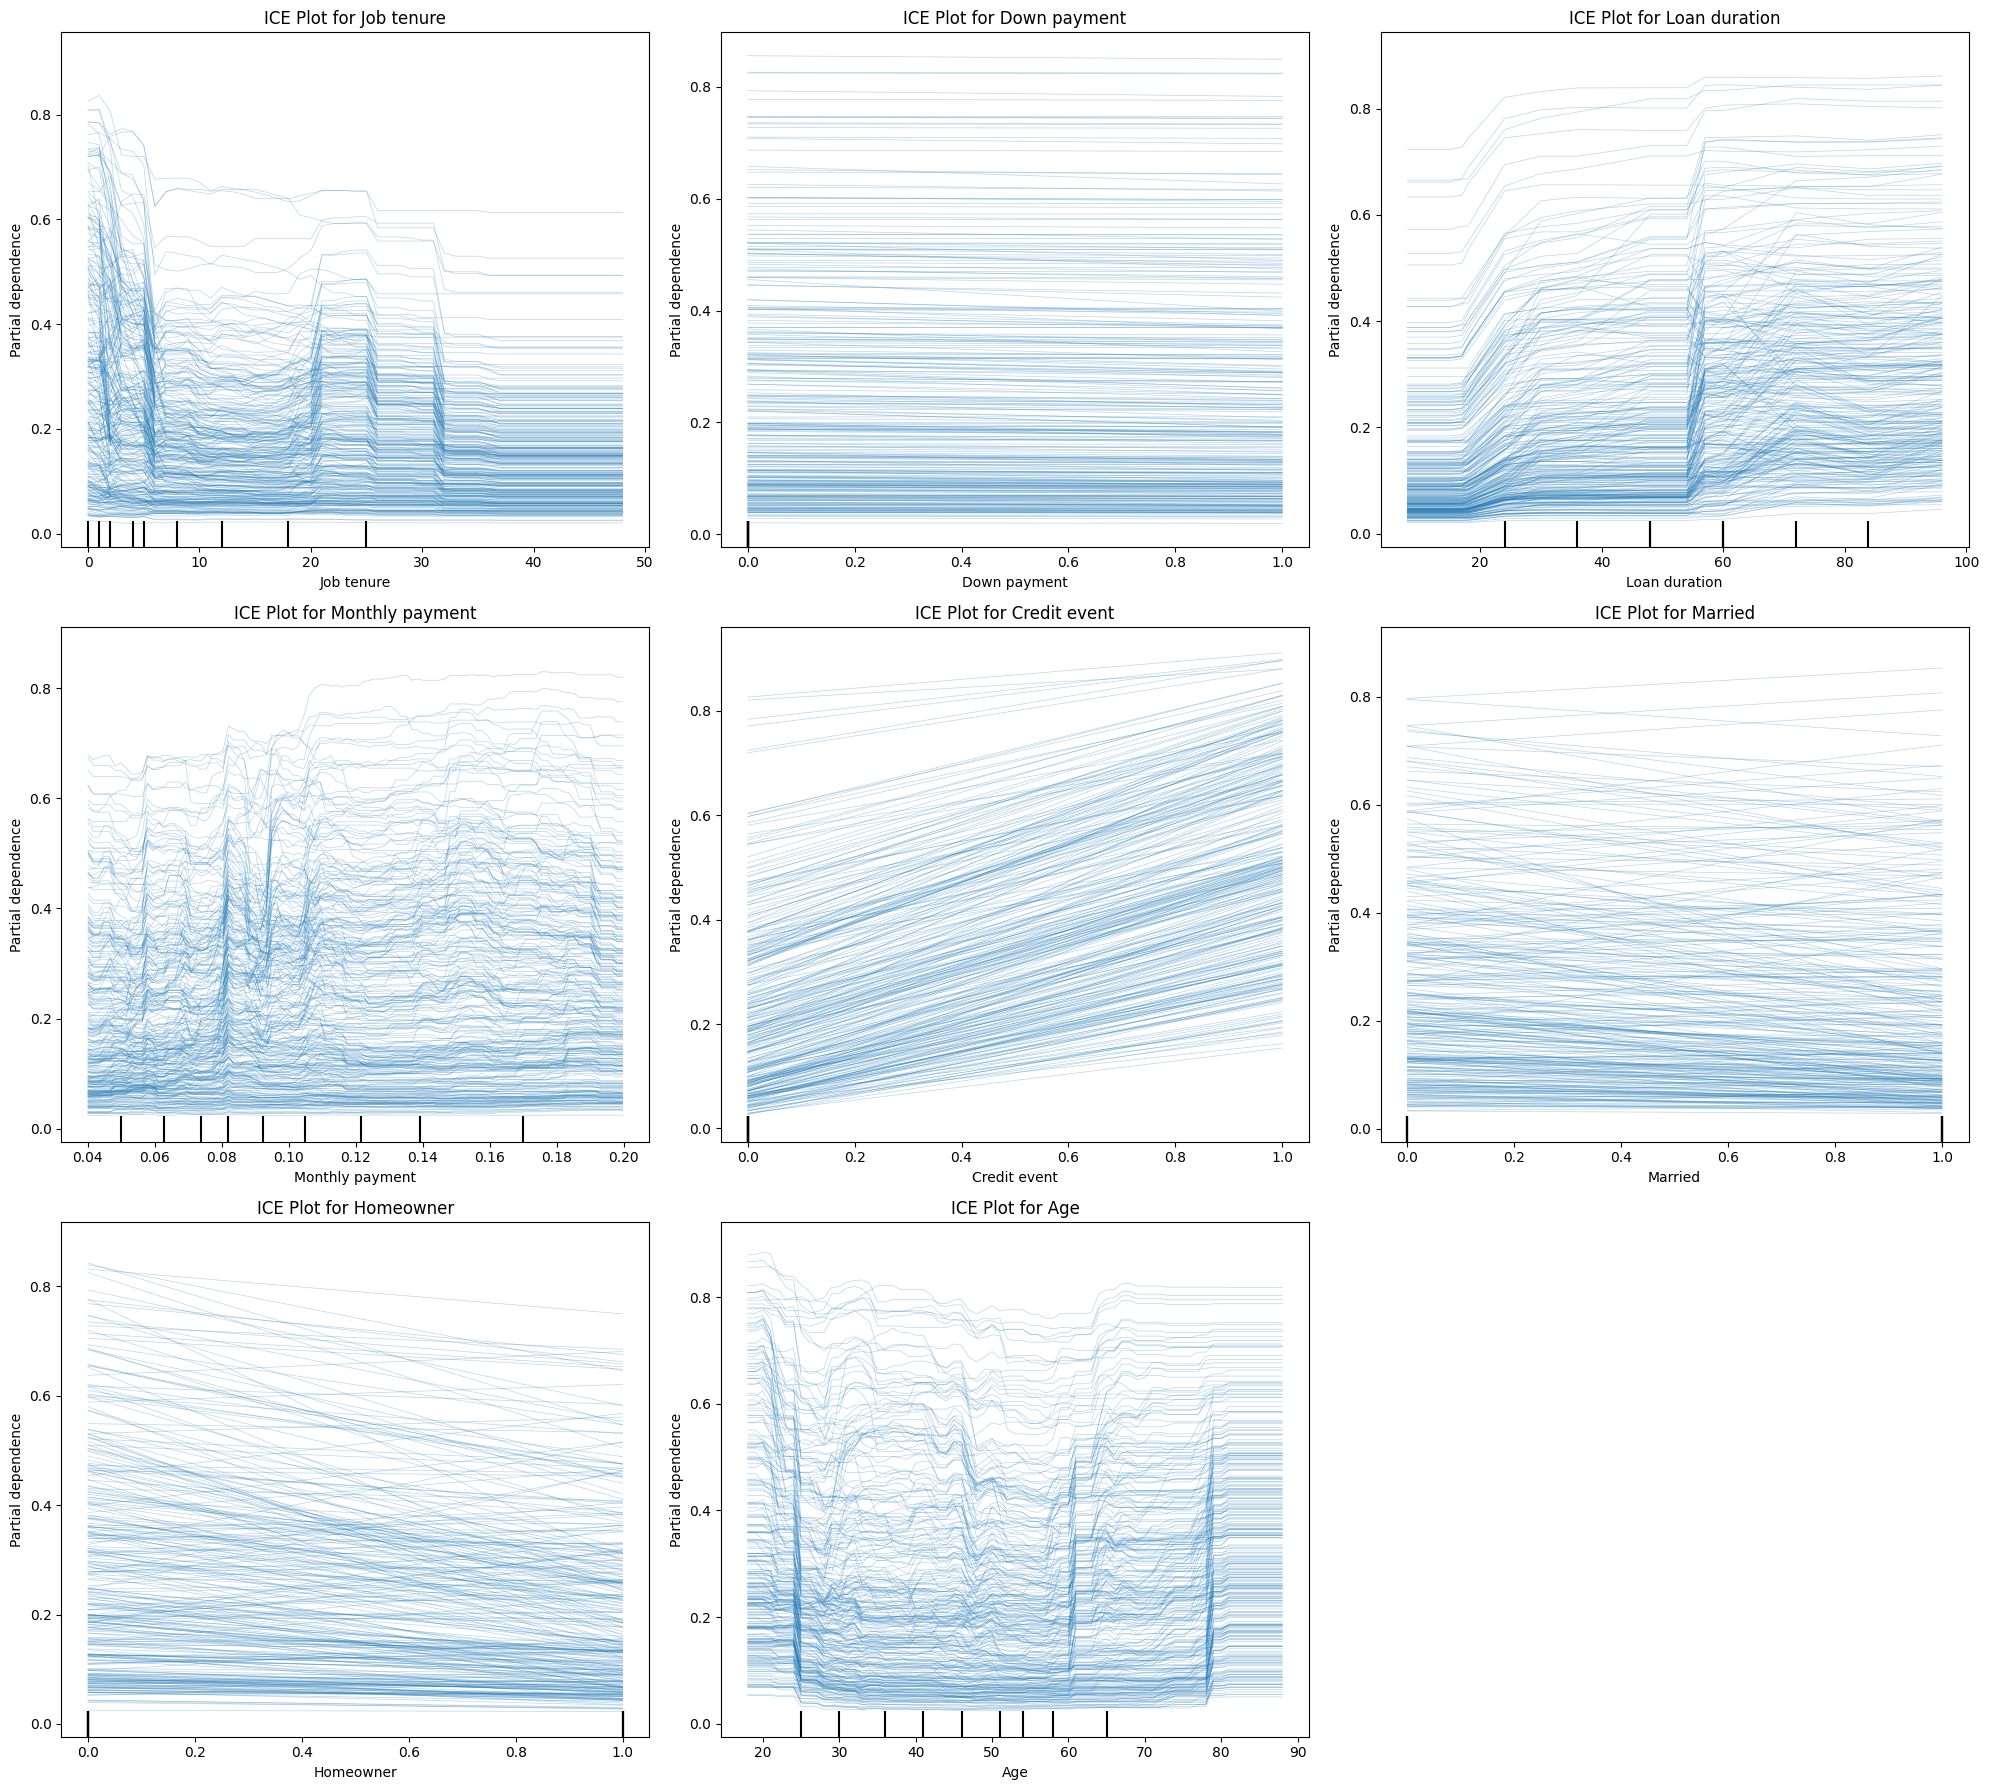

In [26]:
from sklearn.inspection import PartialDependenceDisplay

features = ['Job tenure', 'Down payment', 'Loan duration', 'Monthly payment', 'Credit event', 'Married', 'Homeowner', 'Age']

n_features = len(features)
n_cols = 3
n_rows = (n_features + n_cols - 1) // n_cols

fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 6 * n_rows))
axs = axs.flatten() # Flatten the axs array for easier indexing


# ICE plot for each feature
for i, feature in enumerate(features):
    PartialDependenceDisplay.from_estimator(
        xgb_model, 
        X_test, 
        [feature],  # feature name instead of index
        ax=axs[i], 
        kind='individual', 
        subsample=300,
        n_jobs=-1  # Use all available cores
    )
    axs[i].set_title(f'ICE Plot for {feature}')
    axs[i].set_xlabel(feature)
    axs[i].set_ylabel('Predicted Probability of Default')
    axs[i].grid(True)

for j in range(i+1, len(axs)):
    fig.delaxes(axs[j])

plt.tight_layout()
plt.show()

### Comment ^^^good luck

## Step 7: Local interpretability: Implement the SHAP method to interpret your own model. Compare the results provided in Steps 6 and 7.

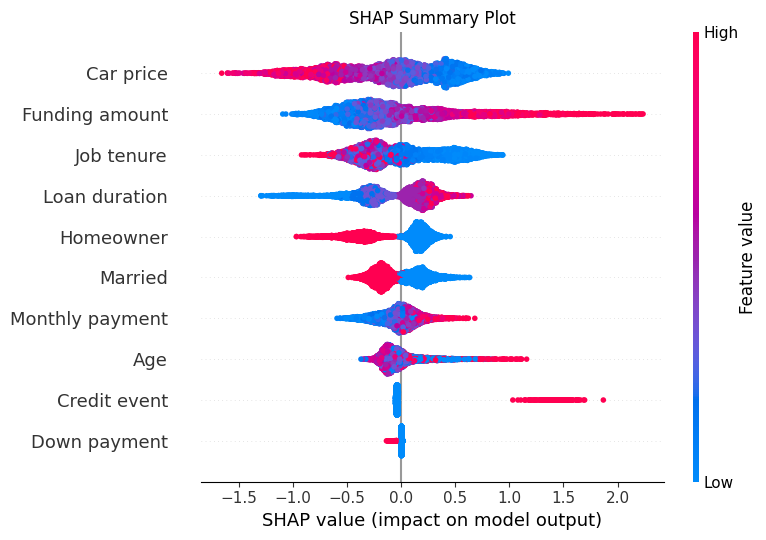

<Figure size 1000x600 with 0 Axes>

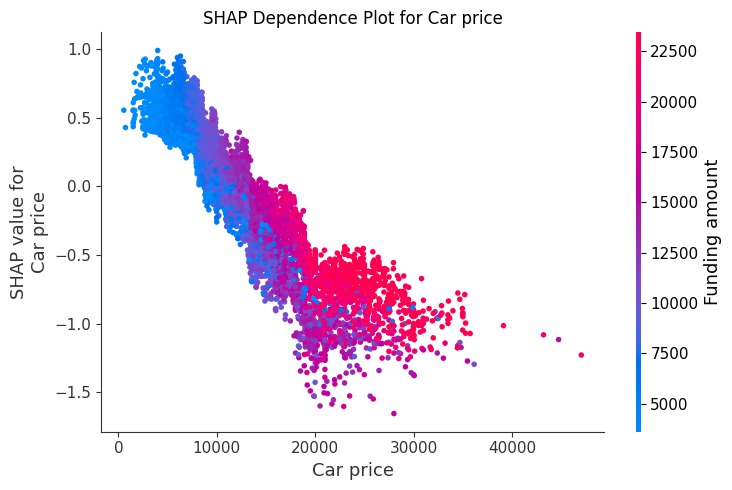

In [27]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Create a SHAP explainer object
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the entire dataset
shap_values = explainer.shap_values(X)

# Summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, plot_type="bar", show=False)
plt.title("SHAP Feature Importance")
plt.tight_layout()
plt.show()

# Detailed summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X, show=False)
plt.title("SHAP Summary Plot")
plt.tight_layout()
plt.show()

# SHAP dependence plot for the most important feature
most_important_feature = X.columns[np.argmax(np.abs(shap_values).mean(0))]
plt.figure(figsize=(10, 6))
shap.dependence_plot(most_important_feature, shap_values, X, show=False)
plt.title(f"SHAP Dependence Plot for {most_important_feature}")
plt.tight_layout()
plt.show()

### Comment ^^^

Now let's look at a few individual predictions:


Explaining prediction for instance 0

Top 5 influential features:
Funding amount: 3087.00 (decreases prediction by 0.4398)
Car price: 4875.00 (increases prediction by 0.3565)
Loan duration: 36.00 (decreases prediction by 0.3397)
Homeowner: 1.00 (decreases prediction by 0.3305)
Job tenure: 34.00 (decreases prediction by 0.3098)


<Figure size 1000x300 with 0 Axes>

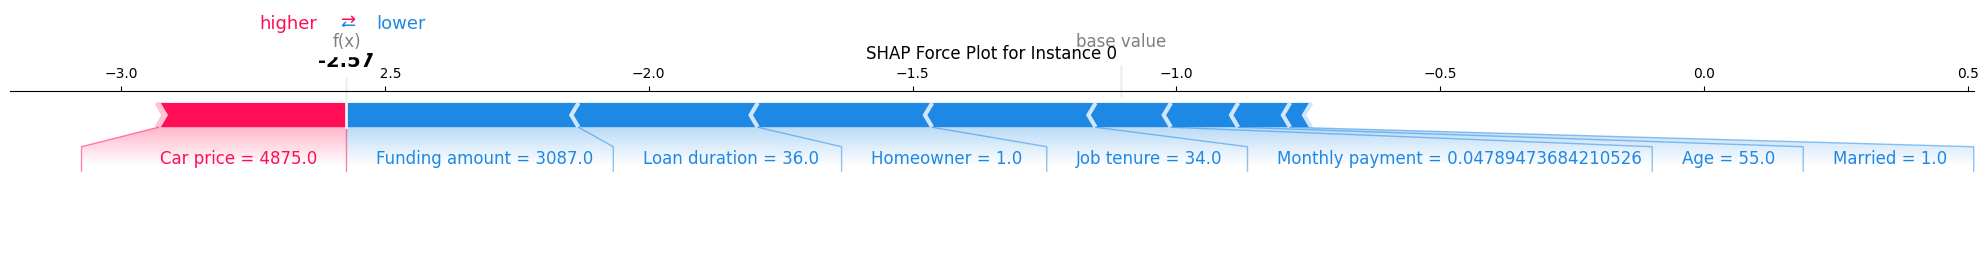


Explaining prediction for instance 1

Top 5 influential features:
Funding amount: 13000.00 (increases prediction by 0.3319)
Homeowner: 0.00 (increases prediction by 0.2121)
Loan duration: 60.00 (increases prediction by 0.1838)
Job tenure: 5.00 (increases prediction by 0.1809)
Married: 0.00 (increases prediction by 0.1244)


<Figure size 1000x300 with 0 Axes>

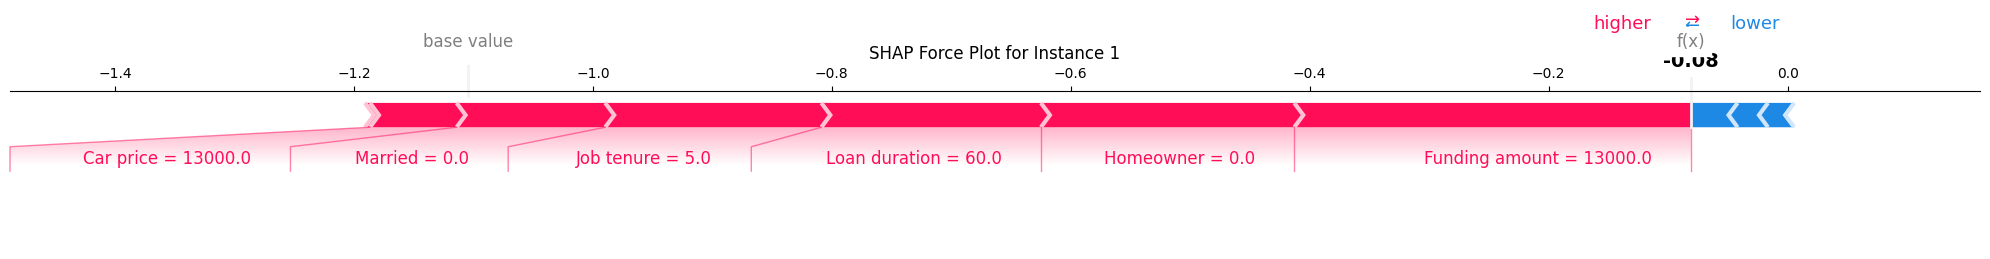


Explaining prediction for instance 2

Top 5 influential features:
Car price: 17190.00 (decreases prediction by 0.4244)
Job tenure: 14.00 (decreases prediction by 0.4039)
Married: 0.00 (increases prediction by 0.2282)
Homeowner: 0.00 (increases prediction by 0.1840)
Loan duration: 60.00 (increases prediction by 0.1668)


<Figure size 1000x300 with 0 Axes>

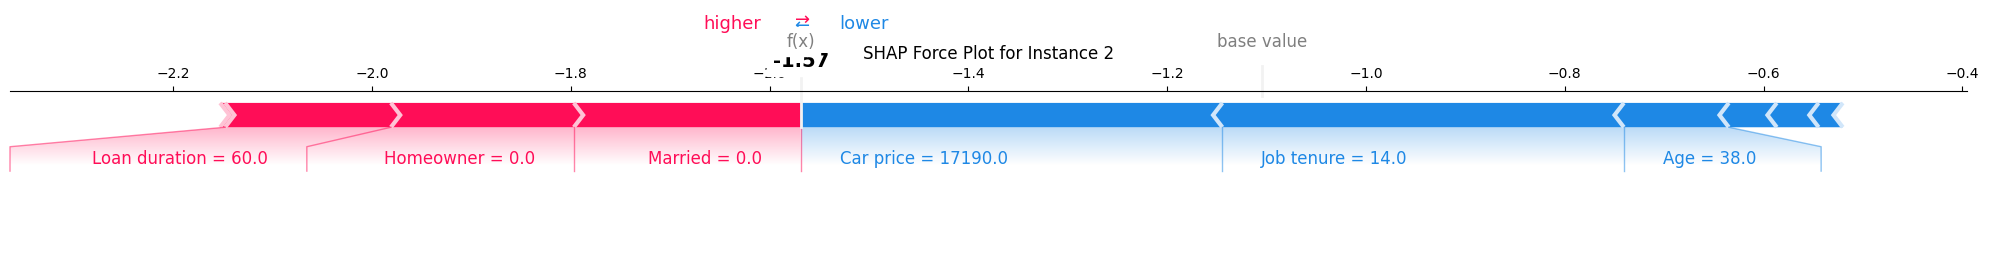

In [28]:
def explain_prediction(instance_index, explainer, X):
    print(f"\nExplaining prediction for instance {instance_index}")
    instance = X.iloc[instance_index:instance_index+1]
    shap_values_instance = explainer.shap_values(instance)
    
    # Display top 5 most influential features
    feature_importance = sorted(zip(instance.columns, shap_values_instance[0]), key=lambda x: abs(x[1]), reverse=True)
    print("\nTop 5 influential features:")
    for feature, shap_value in feature_importance[:5]:
        value = instance.iloc[0][feature]
        impact = "increases" if shap_value > 0 else "decreases"
        print(f"{feature}: {value:.2f} ({impact} prediction by {abs(shap_value):.4f})")
    
    # Create and display force plot
    plt.figure(figsize=(10, 3))
    shap.force_plot(explainer.expected_value, shap_values_instance[0], instance.iloc[0], 
                    matplotlib=True, show=False)
    plt.title(f"SHAP Force Plot for Instance {instance_index}")
    plt.tight_layout()
    plt.show()

for i in range(3):
    explain_prediction(i, explainer, X)

## Step 8: Performance interpretability: Implement the permutation importance method and/or the XPER method to identify the main drivers of the predictive performance of your model. Are the drivers of the performance metric (Step 8) similar to the drivers of the individual forecasts identified by SHAP (Step 7).

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score

def plot_permutation_importance(result, feature_names):
    sorted_idx = result.importances_mean.argsort()
    importances = pd.DataFrame(
        result.importances[sorted_idx].T,
        columns=feature_names[sorted_idx],
    )
    ax = importances.plot.box(vert=False, whis=10)
    ax.set_title("Permutation Importances")
    ax.axvline(x=0, color="k", linestyle="--")
    ax.set_xlabel("Decrease in ROC AUC")
    ax.figure.tight_layout()
    plt.show()

# Assuming xgb_model, X_test, y_test are already defined
result = permutation_importance(
    xgb_model, X_test, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='roc_auc'
)

# Plot the permutation importance results
plot_permutation_importance(result, X_test.columns)

# Print the importance scores
importance_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance': result.importances_mean,
    'std': result.importances_std
})
print(importance_df.sort_values('importance', ascending=False))

# Compare with SHAP results
print("\nComparing with SHAP results:")
shap_importance = pd.DataFrame({
    'feature': X_test.columns,
    'importance': np.abs(shap_values).mean(0)
})
shap_importance = shap_importance.sort_values('importance', ascending=False)
print(shap_importance)

# Calculate Spearman rank correlation between permutation importance and SHAP importance
correlation = importance_df['importance'].corr(shap_importance['importance'], method='spearman')
print(f"\nSpearman rank correlation between permutation importance and SHAP importance: {correlation:.4f}")

           feature  importance       std
3   Funding amount    0.122910  0.009879
2        Car price    0.078272  0.009519
0       Job tenure    0.041688  0.007919
1              Age    0.021079  0.003954
7     Credit event    0.015863  0.004952
5    Loan duration    0.013527  0.005869
9        Homeowner    0.012538  0.004093
6  Monthly payment    0.009412  0.004192
8          Married    0.007298  0.005341
4     Down payment    0.000201  0.000384

Comparing with SHAP results:
           feature  importance
2        Car price    0.425517
3   Funding amount    0.420505
0       Job tenure    0.304683
5    Loan duration    0.265903
9        Homeowner    0.262925
8          Married    0.184161
6  Monthly payment    0.131013
1              Age    0.129611
7     Credit event    0.069025
4     Down payment    0.009515

Spearman rank correlation between permutation importance and SHAP importance: 0.6848


In [30]:
from XPER.compute.Performance import ModelPerformance

# Use a subset of your data to shorten runtime (e.g., 10% of the data)
train_sample = X_train.sample(frac=0.1, random_state=42)  # Sample from X_train
X_train_small = train_sample.reset_index(drop=True)        # Reset index for X_train
y_train_small = y_train.loc[train_sample.index].reset_index(drop=True)  # Subset and reset index for y_train

test_sample = X_test.sample(frac=0.1, random_state=42)    # Sample from X_test
X_test_small = test_sample.reset_index(drop=True)          # Reset index for X_test
y_test_small = y_test.loc[test_sample.index].reset_index(drop=True)    # Subset and reset index for y_test

# Update the XPER object with the smaller dataset
XPER_ = ModelPerformance(X_train_small.values, y_train_small.values, X_test_small.values, y_test_small.values, xgb_model)

# Calculate XPER values for the model's performance
XPER_values = XPER_.calculate_XPER_values(["Accuracy"]) # Accuracy


Performing Computation:   0%|          | 0/1 [00:00<?, ?it/s]

1022


Performing Computation: 100%|██████████| 1/1 [02:36<00:00, 156.53s/it]


In [31]:
print("Number of features in X_train:", X_train.shape[1])
print("Number of features in X_test:", X_test.shape[1])

Number of features in X_train: 10
Number of features in X_test: 10


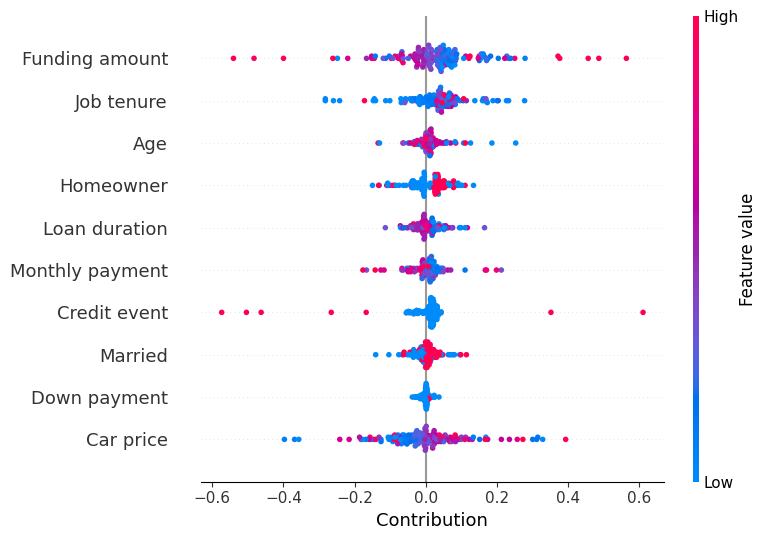

In [32]:
from XPER.viz.Visualisation import visualizationClass as viz

viz.bar_plot(XPER_values=XPER_values, X_test=pd.DataFrame(X_test_small), labels=X_test_small.columns, p=6,percentage=True)

viz.beeswarn_plot(XPER_values=XPER_values,X_test=pd.DataFrame(X_test_small), labels = list(X_test_small.columns))

viz.force_plot(XPER_values=XPER_values, instance=1, X_test=X_test_small, variable_name=X_test_small.columns, figsize=(16,4))

## Step 9: Assess the fairness of your own model with respect to age (protected attribute). Use a statistical test for the following three fairness definitions: Statistical Parity and Conditional Statistical Parity (groups are given in the dataset). Discuss your results.

In [33]:
from scipy.stats import chi2_contingency

# Preparing the data
age_treshold = 60
X_test['Age_Group'] = X_test['Age'].apply(lambda x: 'Young' if x < age_treshold else 'Old')
results_df = X_test.copy()
results_df['y_pred'] = y_pred

print(f"1. Statistical Parity - Age treshold used : {age_treshold}")
print("_" * 60)



default_rate = results_df.groupby('Age_Group')['y_pred'].mean()
print("\nDefault rate by Age Group:")
print(default_rate)

stat_parity_diff = abs(default_rate['Young'] - default_rate['Old'])
print(f"\nStatistical Parity Difference: {stat_parity_diff:.4f}")

contingency_table = pd.crosstab(results_df['Age_Group'], results_df['y_pred'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared test p-value: {p:.4f}")

print( "\n"+ "–" * 60)
print(f"\nThe p-value of {p:.5f} suggests {'significant' if p < 0.05 else 'no significant'} difference in predictions based on age")


1. Statistical Parity - Age treshold used : 60
____________________________________________________________

Default rate by Age Group:
Age_Group
Old      0.067194
Young    0.144363
Name: y_pred, dtype: float64

Statistical Parity Difference: 0.0772
Chi-squared test p-value: 0.0013

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

The p-value of 0.00133 suggests significant difference in predictions based on age


Note : It is interesting to see that when using 60 as the "old" treshold we get a p-value << 0.05 meaning that our model is unfair for certain age while if we shift the treshold a bit our model isn't considered unfair anymore :

In [34]:
from scipy.stats import chi2_contingency

# Prepare the data
age_treshold = 67
X_test['Age_Group'] = X_test['Age'].apply(lambda x: 'Young' if x < age_treshold else 'Old')
results_df = X_test.copy()
results_df['y_pred'] = y_pred

print(f"1. Statistical Parity - Age treshold used : {age_treshold}")
print("_" * 60)



default_rate = results_df.groupby('Age_Group')['y_pred'].mean()
print("\nDefault rate by Age Group:")
print(default_rate)

stat_parity_diff = abs(default_rate['Young'] - default_rate['Old'])
print(f"\nStatistical Parity Difference: {stat_parity_diff:.4f}")

contingency_table = pd.crosstab(results_df['Age_Group'], results_df['y_pred'])
chi2, p, _, _ = chi2_contingency(contingency_table)
print(f"Chi-squared test p-value: {p:.4f}")

print( "\n"+ "–" * 60)
print(f"\nThe p-value of {p:.5f} suggests {'significant' if p < 0.05 else 'no significant'} difference in predictions based on age")

1. Statistical Parity - Age treshold used : 67
____________________________________________________________

Default rate by Age Group:
Age_Group
Old      0.079365
Young    0.136029
Name: y_pred, dtype: float64

Statistical Parity Difference: 0.0567
Chi-squared test p-value: 0.0961

––––––––––––––––––––––––––––––––––––––––––––––––––––––––––––

The p-value of 0.09606 suggests no significant difference in predictions based on age


In fact 66 years old seems to be the pivot age treshold for fairness with our model !

In [35]:
# 2. Conditional Statistical Parity

age_treshold = 60
X_test['Age_Group'] = X_test['Age'].apply(lambda x: 'Young' if x < age_treshold else 'Old')
results_df = X_test.copy()
results_df['y_pred'] = y_pred


print(f"Conditional Statistical Parity - Age treshold used : {age_treshold}")
print("_" * 60)

for credit_event in [0, 1]:
    subset = results_df[results_df['Credit event'] == credit_event]
    cond_default_rate = subset.groupby('Age_Group')['y_pred'].mean()
    cond_stat_parity_diff = abs(cond_default_rate['Young'] - cond_default_rate['Old'])
    
    print(f"\nCredit Event = {credit_event}")
    print("Conditional default rate:")
    print(cond_default_rate)
    print(f"Conditional Statistical Parity Difference: {cond_stat_parity_diff:.4f}")
    
    cond_contingency = pd.crosstab(subset['Age_Group'], subset['y_pred'])
    _, cond_p, _, _ = chi2_contingency(cond_contingency)
    print(f"Conditional Chi-squared test p-value: {cond_p:.4f}")


Conditional Statistical Parity - Age treshold used : 60
____________________________________________________________

Credit Event = 0
Conditional default rate:
Age_Group
Old      0.048583
Young    0.129707
Name: y_pred, dtype: float64
Conditional Statistical Parity Difference: 0.0811
Conditional Chi-squared test p-value: 0.0004

Credit Event = 1
Conditional default rate:
Age_Group
Old      0.833333
Young    0.605263
Name: y_pred, dtype: float64
Conditional Statistical Parity Difference: 0.2281
Conditional Chi-squared test p-value: 0.5335


### Comment !

## Step 10: Implement a FPDP using a fairness measure. Discuss your results.

1. Define Fairness Measure: Differential Impact

Differential Impact measures the ratio of the favorable outcome rates between protected and unprotected groups. A common threshold is that this ratio should be at least 80% (the “80% rule”) to consider the model fair.

Dataset loaded. Shape of X: (7430, 10)
Unique values in y: [0 1]
Processing feature: Down payment, Type: cat
Number of unique values: 2
Processing feature: Credit event, Type: cat
Number of unique values: 2
Processing feature: Married, Type: cat
Number of unique values: 2
Processing feature: Homeowner, Type: cat
Number of unique values: 2
Processing feature: Job tenure, Type: num
Number of unique values: 59
Processing feature: Car price, Type: num
Number of unique values: 467
Processing feature: Loan duration, Type: num
Number of unique values: 91
Processing feature: Funding amount, Type: num
Number of unique values: 296
Processing feature: Monthly payment, Type: num
Number of unique values: 264


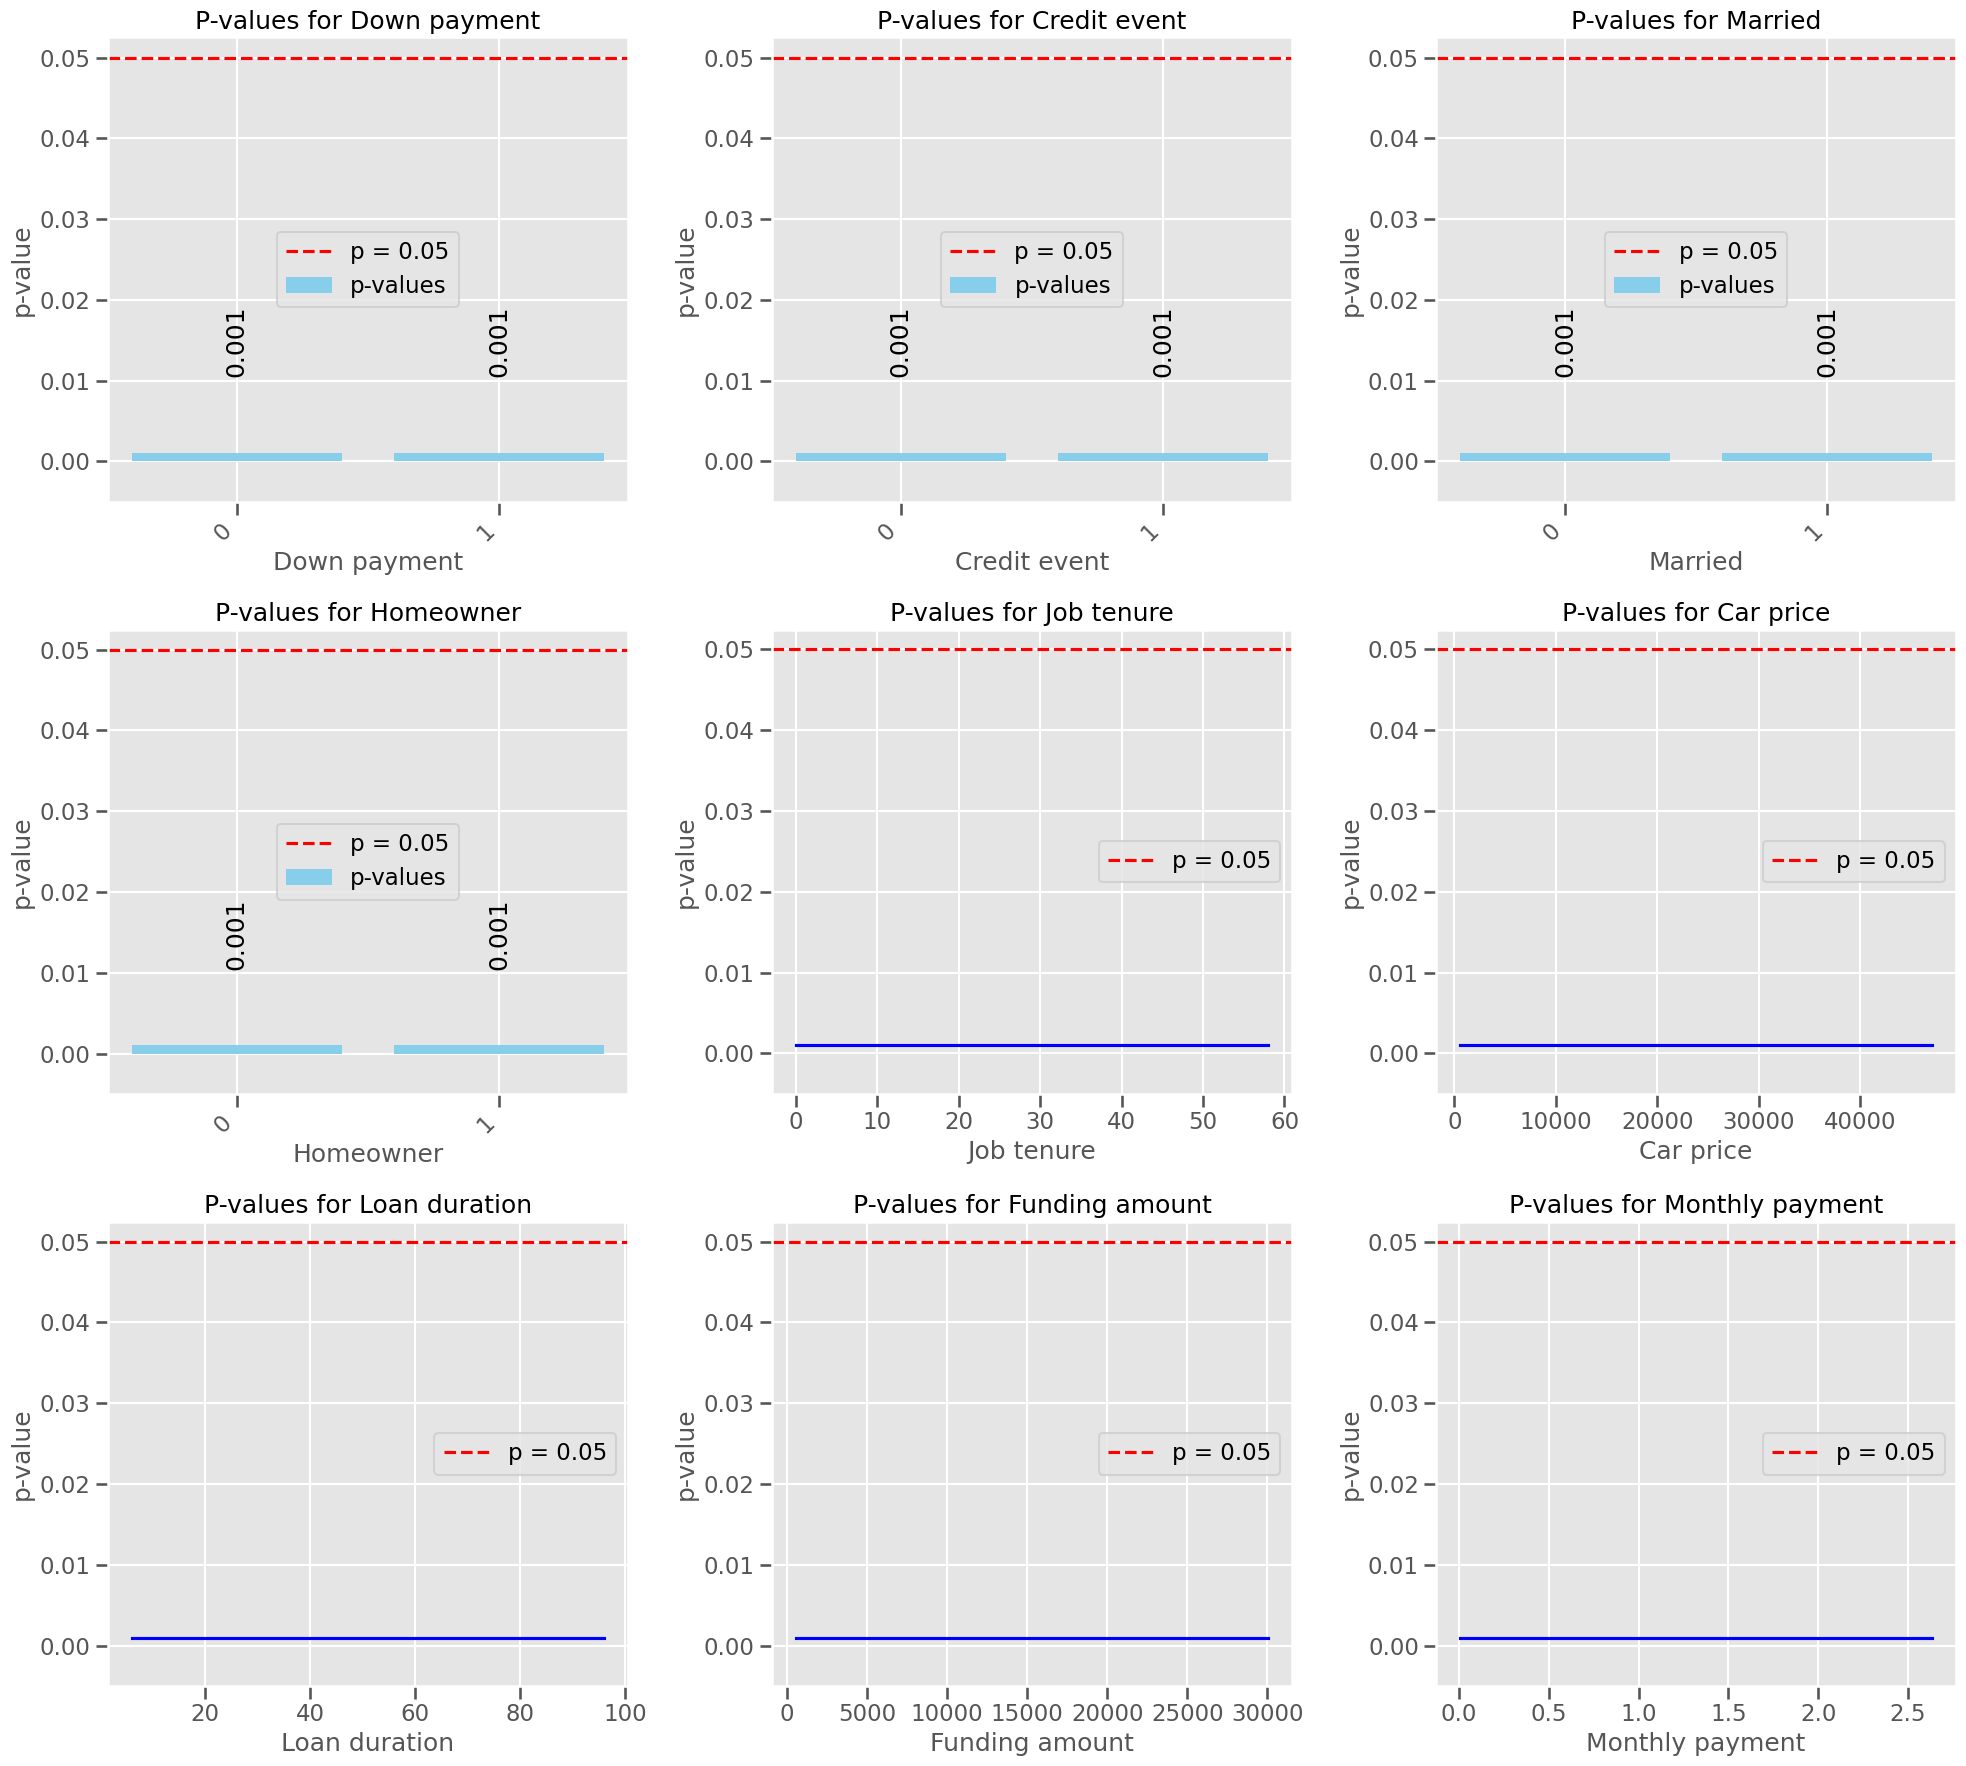


P-values for each feature:
Down payment: 0.001
Credit event: 0.001
Married: 0.001
Homeowner: 0.001
Job tenure: 0.001
Car price: 0.001
Loan duration: 0.001
Funding amount: 0.001
Monthly payment: 0.001


In [43]:
import pandas as pd
import numpy as np
import joblib
from scipy.stats import chi2_contingency
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set a prettier plot style
plt.style.use('ggplot')
sns.set_context('talk')

categorical_features = ['Down payment', 'Credit event', 'Married', 'Homeowner']
num_features = ['Job tenure', 'Car price', 'Loan duration', 'Funding amount', 'Monthly payment']

def load_dataset(target_col, drop_cols):
    """
    Load the dataset, drop unnecessary columns, and return features and target.
    """
    df = pd.read_excel('dataproject2024.xlsx')
    
    # Drop unnecessary columns
    df = df.drop(columns=drop_cols)
    
    # Separate features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    return X, y

def create_contingency_table(df, sensitive_attr, outcome_col):
    """
    Create a contingency table with counts of favorable and unfavorable outcomes for each group.
    """
    contingency_table = pd.crosstab(df[sensitive_attr], df[outcome_col])
    return contingency_table

def chi_square_test(contingency_table):
    """
    Perform the Chi-Square test on the contingency table and return the p-value.
    """
    _, p, _, _ = chi2_contingency(contingency_table)
    return p

def fairness_pdp_per_feature(ax, model, X, y, feature, feature_type, p_value_dict):
    """
    Create the fairness partial dependence plot for one feature on the provided axis.
    """
    # Determine the list of values (categories or numerical range) to iterate over
    if feature_type == 'cat':
        iter_list = sorted(X[feature].unique())
    elif feature == 'Monthly payment':
        iter_list = np.arange(X[feature].min(), X[feature].max() + 0.0100, 0.0100).tolist()
    elif feature in ['Funding amount', 'Car price']:
        iter_list = np.arange(X[feature].min(), X[feature].max() + 100, 100).tolist()
    else:
        iter_list = np.arange(X[feature].min(), X[feature].max() + 1, 1).tolist()

    print(f"Processing feature: {feature}, Type: {feature_type}")
    print(f"Number of unique values: {len(iter_list)}")

    p_values = []

    for modality in iter_list:
        X_copy = X.copy()
        X_copy[feature] = modality

        y_hat = model.predict(X_copy)

        df = pd.concat([X_copy, pd.Series(y)], axis=1)
        df['y_hat'] = y_hat

        contingency_table = create_contingency_table(df, 'Age', 'y_hat')
        
        p_value = round(chi_square_test(contingency_table), 3)
        
        # Adjust small or zero p-values for better visibility
        if p_value == 0:
            p_value = 1e-3
        
        p_values.append(p_value)

    # Store the minimum p-value for this feature
    p_value_dict[feature] = min(p_values)

    # Plotting the p-values
    if feature_type == 'cat':
        ax.bar(iter_list, p_values, label='p-values', color='skyblue')
        ax.set_xticks(np.arange(len(iter_list)))
        ax.set_xticklabels(iter_list, rotation=45, ha='right')
        for i, p_value in enumerate(p_values):
            ax.text(i, p_value + 0.01, f'{p_value:.3f}', ha='center', rotation=90)
    else:
        ax.plot(iter_list, p_values, linestyle='-', color='b')
    
    ax.axhline(y=0.05, color='r', linestyle='--', label='p = 0.05')  
    ax.set_ylim(bottom=-0.005)
    ax.set_xlabel(f'{feature}')
    ax.set_ylabel('p-value')
    ax.set_title(f'P-values for {feature}')
    ax.legend()

def plot_fairness_pdp_for_all_features(model, X, y, categorical_features, num_features):
    """
    Generate fairness partial dependence plots for all features in one figure and return p-values for each feature.
    """
    total_features = len(categorical_features) + len(num_features)
    cols = 3
    rows = (total_features + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(20, rows * 6))
    axes = axes.flatten()

    p_value_dict = {}

    for i, feature in enumerate(categorical_features):
        fairness_pdp_per_feature(axes[i], model, X, y, feature, feature_type='cat', p_value_dict=p_value_dict)

    for j, feature in enumerate(num_features):
        fairness_pdp_per_feature(axes[len(categorical_features) + j], model, X, y, feature, feature_type='num', p_value_dict=p_value_dict)

    for k in range(len(categorical_features) + len(num_features), len(axes)):
        axes[k].set_visible(False)

    plt.tight_layout()
    plt.show()

    return p_value_dict

# Main execution
if __name__ == "__main__":
    # Step 1: Load dataset
    X, y = load_dataset(target_col="Default (y)", drop_cols=['ID', 'Pred_default (y_hat)', 'PD', 'Group'])
    
    print("Dataset loaded. Shape of X:", X.shape)
    print("Unique values in y:", np.unique(y))

    # Step 2: Load model (assuming xgb_model is already defined and trained)
    # Replace this with your actual model loading code
    # For example: model = joblib.load('path_to_your_model.pkl')
    model = xgb_model  # You need to define or load xgb_model before this line

    # Step 3: Plot fairness pdp and generate p-value for each feature
    feature_p_values = plot_fairness_pdp_for_all_features(model, X, y, categorical_features, num_features)

    # Display the p-value for each feature
    print("\nP-values for each feature:")
    for feature, p_value in feature_p_values.items():
        print(f"{feature}: {p_value}")